## 7.1 Defining the autoregressive integrated moving average model

An autoregressive integrated moving average process is the combination of an autoregressive process AR(p), integration I(d), and the moving average process MA(q).
Just like the ARMA process, the ARIMA process states that the present value is dependent on past values, coming from the AR(p) portion, and past errors, coming from the MA(q) portion. However, instead of using the original series, denoted as $y_t$, the ARIMA process uses the differenced series, denoted as $y'_t$. Note that $y'_t$ can represent a series that has been differenced more than once.

Therefore, the mathematical expression of the ARIMA(p,d,q) process states that the present value of the differenced series $y'_t$ is equal to the sum of a constant C, past values of the differenced series $\phi_t y'_{t-p}$, the mean of the differenced series $\mu$, past error terms $\theta_q \epsilon'_{t-q}$ and a current error term $\epsilon_t$, as shown in equation 7.1.
<br/>
<center>$y'_t = C + \phi_1 y'_{1-p} + ... + \phi_t y'_{t-p} + \theta_1 \epsilon'_{1-q} + \theta_t \epsilon'_{t-q} + \epsilon_t$</center>

Just like in the ARMA process, the order p determines how many lagged values of the series are included in the model, while the order q determines how many lagged error terms are included in the model. However, in equation 7.1 you’ll notice that there is no order d explicitly displayed.

Here, the order d is defined as the order of integration. Integration is simply the reverse of differencing. The order of integration is thus equal to the number of times a series has been differenced to become stationary.

If we difference a series once and it becomes stationary, then d = 1. If a series is differenced twice to become stationary, then d = 2.

A time series that can be rendered stationary by applying differencing is said to be an integrated series. In the presence of a non-stationary integrated time series, we can use the ARIMA(p,d,q) model to produce forecasts.

Thus, in simple terms, the ARIMA model is simply an ARMA model that can be applied on non-stationary time series. Whereas the ARMA(p,q) model requires the series to be stationary before fitting an ARMA(p,q) model, the ARIMA(p,d,q) model can be used on non-stationary series. We must simply find the order of integration d, which corresponds to the minimum number of times a series must be differenced to become stationary.

## 7.2 Modifying the general modeling procedure to account for non-stationary series

The next iteration of the general modeling procedure will include a step to determine the order of integration d. That way, we can apply the same procedure but using an ARIMA(p,d,q) model, which will allow us to forecast non-stationary time series.

From the previous section, we know that the order of integration d is simply the minimum number of times a series must be differenced to become stationary. Therefore, if a series is stationary after being differenced once, then d = 1. If it is stationary after being differenced twice, then d = 2. In my experience, a time series rarely needs to be differenced more than twice to become stationary.

We can add a step such that when transformations are applied to the series, we set the value of d to the number of times the series was differenced. Then, instead of fitting many ARMA(p,q) models, we fit many ARIMA(p,d,q) models. The rest of the procedure remains the same, as we still use the AIC to select the best model and study its residuals.
<br/>
<center><img src="https://i.imgur.com/WIy1RFQ.png" alt="Steps to recognize an ARIMA(p,d,q) process" title="Steps to recognize an ARIMA(p,d,q) process" /></center>

Note that in the case where d = 0, it is equivalent to an ARMA(p,q) model. This also means that the series did not need to be differenced to be stationary. It must also be specified that the ARMA(p,q) model can only be applied on a stationary series, whereas the ARIMA(p,d,q) model can be applied on a series that has not been differenced.

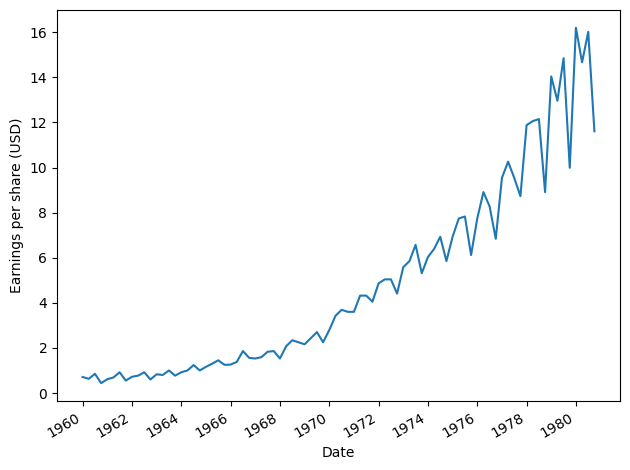

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./jj.csv')

fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

Following our procedure, we must check if the data is stationary. Figure 7.5 shows a positive trend, as the quarterly EPS tends to increase over time. Nevertheless, we can apply the augmented Dickey-Fuller (ADF) test to determine if it is stationary or not.

In [3]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


This block of code returns an ADF statistic of 2.74 with a p-value of 1.0. Since the ADF statistic is not a large negative number, and the p-value is larger than 0.05, we cannot reject the null hypothesis, meaning that our series is not stationary.

We need to determine how many times the series must be differenced to become stationary. This will then set the order of integration d. We can apply a first-order differencing and test for stationarity.

In [4]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


This results in an ADF statistic of –0.41 and a p-value of 0.9. Again, the ADF statistic is not a large negative number, and the p-value is larger than 0.05. Therefore, we cannot reject the null hypothesis and we must conclude that after a first-order differencing, the series is not stationary.

Let’s try differencing again to see if the series becomes stationary:

In [5]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793155
p-value: 0.006051099869603682


This results in an ADF statistic of –3.59 and a p-value of 0.006. Now that we have a p-value smaller than 0.05 and a large negative ADF statistic, we can reject the null hypothesis and conclude that our series is stationary. It took two rounds of differencing to make our data stationary, which means that our order of integration is 2, so d = 2.

Before we move on to fitting different combinations of ARIMA(p,d,q) models, we must separate our data into train and test sets. We will hold out the last year of data for testing. This means that we will fit the model with data from 1960 to 1979 and predict the quarterly EPS in 1980 to evaluate the quality of our model against the observed values in 1980. In figure 7.6 the testing period is the shaded area.

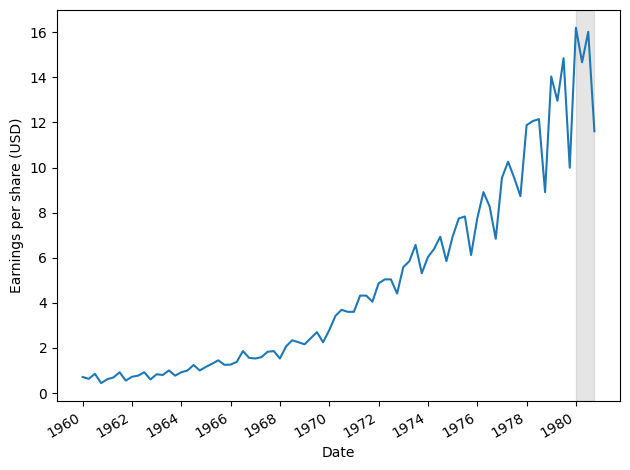

In [6]:
fig, ax = plt.subplots()

ax.plot(df.date, df.data)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

To fit the many ARIMA(p,d,q) models, we’ll define the optimize_ARIMA function. It is almost identical to the optimize_ARMA function that we defined in chapter 6, only this time we’ll add the order of integration d as an input to the function. The remainder of the function stays the same, as we fit the different models and order them by ascending AIC in order to select the model with the lowest AIC. The optimize_ARIMA function is shown in the following listing.

In [29]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

With the function in place, we can define a list of possible values for the orders p and q. In this case, we’ll try the values 0, 1, 2, and 3 for both orders and generate the list of unique (p,q) combinations.

In [33]:
from itertools import product

ps = range(1, 4, 1)
qs = range(1, 4, 1)
d = 2

order_list = list(product(ps, qs))

Note that we do not give a range of values for the parameter d because it has a very specific definition: it is the number of times a series must be differenced to become stationary. Hence, it must be set to a specific value, which in this case is 2.

Furthermore, d must be constant in order to compare models using the AIC. Varying d would change the likelihood function used in the calculation of the AIC value, so comparing models using the AIC as a criterion would not be valid anymore.

We can now run the optimize_ARIMA function using the training set. The function returns a DataFrame with the model that has the lowest AIC at the top.

In [34]:
train = df.data[:-4]
result_df = optimize_ARIMA(train, order_list, d)

result_df

  0%|          | 0/9 [00:00<?, ?it/s]

/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/sandra/anaconda3/lib/python

,"(p,q)",AIC
0,"(3, 3)",115.267686
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(2, 3)",220.666929
4,"(1, 3)",228.267680
5,"(1, 2)",228.935764
6,"(2, 2)",229.974686
7,"(2, 1)",234.501112
8,"(1, 1)",236.117297


The returned DataFrame shows that a value of 3 for both p and q results in the lowest AIC. Therefore, an ARIMA(3,2,3) model seems to be the most suitable for this situation. Now let’s assess the validity of the model by studying its residuals.

To do so, we’ll fit an ARIMA(3,2,3) model on the training set and display the residuals’ diagnostics using the plot_diagnostics method.

In [35]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.634
Date:                Mon, 19 Sep 2022   AIC                            115.268
Time:                        17:46:26   BIC                            131.765
Sample:                             0   HQIC                           121.872
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9996      0.037    -26.926      0.000      -1.072      -0.927
ar.L2         -0.9882      0.040    -24.899      0.000      -1.066      -0.910
ar.L3         -0.9758      0.026    -37.662      0.0

/home/sandra/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


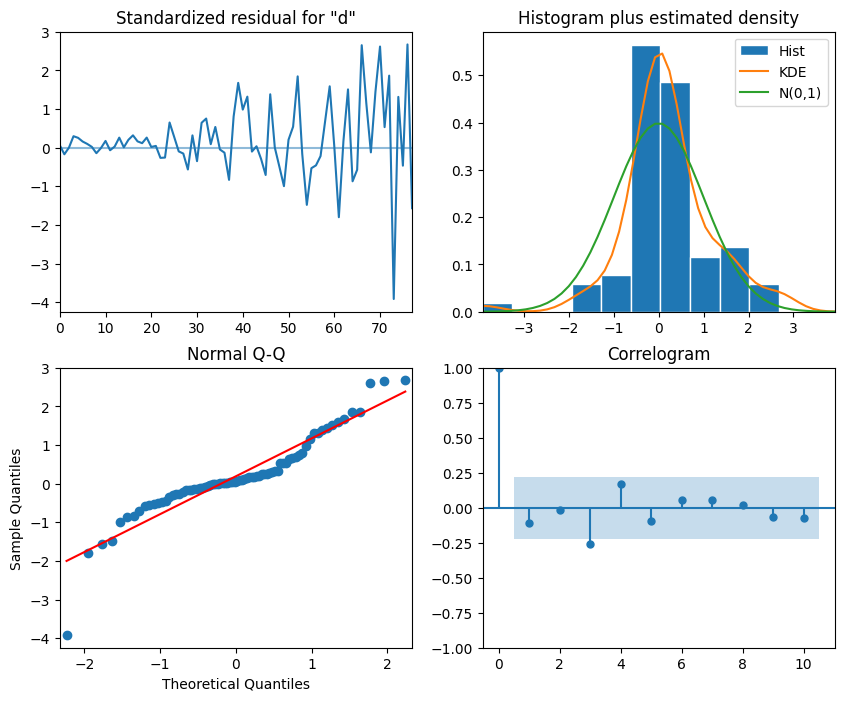

In [36]:
model_fit.plot_diagnostics(figsize=(10,8));

In figure 7.7, the top-left plot shows the residuals over time. While there is no trend in the residuals, the variance does not seem to be constant, which is a discrepancy in comparison to white noise. At the top right is the distribution of the residuals. We can see it is fairly close to a normal distribution. The Q-Q plot leads us to the same conclusion, as it displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. Finally, by looking at the correlogram at the bottom right, we can see that a coefficient seems to be significant at lag 3. However, since it is not preceded by any significant autocorrelation coefficients, we can assume that this is due to chance. Therefore, we can say that the correlogram shows no significant coefficients after lag 0, just like white noise.

Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, as it means that the model’s errors are random.

The last step is to evaluate the residuals from a quantitative standpoint. We’ll thus apply the Ljung-Box test to determine whether the residuals are correlated. We’ll apply the test on the first 10 lags and study the p-values. If all p-values are greater than 0.05, we cannot reject the null hypothesis and we’ll conclude that the residuals are not correlated, just like white noise.

In [37]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

      lb_stat  lb_pvalue
1    1.659733   0.197639
2    1.662010   0.435611
3    7.242626   0.064554
4    9.212735   0.055997
5    9.832514   0.080122
6   10.074017   0.121569
7   10.323840   0.170952
8   10.356025   0.240921
9   10.696107   0.297116
10  11.136522   0.346981


Running the Ljung-Box test on the first 10 lags of the model’s residuals returns a list of p-values that are all larger than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are not correlated, just like white noise.

Our ARIMA(3,2,3) model has passed all the checks, and it can now be used for forecasting. Remember that our test set is the last four data points, corresponding to the four quarterly EPS reported in 1980. As a benchmark for our model, we will use the naive seasonal method. This means that we’ll take the EPS of the first quarter of 1979 and use it as a forecast for the EPS of the first quarter of 1980. Then the EPS of the second quarter of 1979 will be used as a forecast for the EPS of the second quarter of 1980, and so on. Remember that we need a benchmark, or a baseline model, when modeling to determine whether the model we develop is better than a naive method.

The performance of a model must always be assessed relative to a baseline model.

In [38]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values

/tmp/ipykernel_1466609/3725327162.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['data'].iloc[76:80].values


With our baseline in place, we can now make forecasts using the ARIMA(3,2,3) model and store the results in the ARIMA_pred column.

In [39]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

/tmp/ipykernel_1466609/2978832924.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


Let’s visualize our forecasts to see how close the predictions from each method are to the observed values.

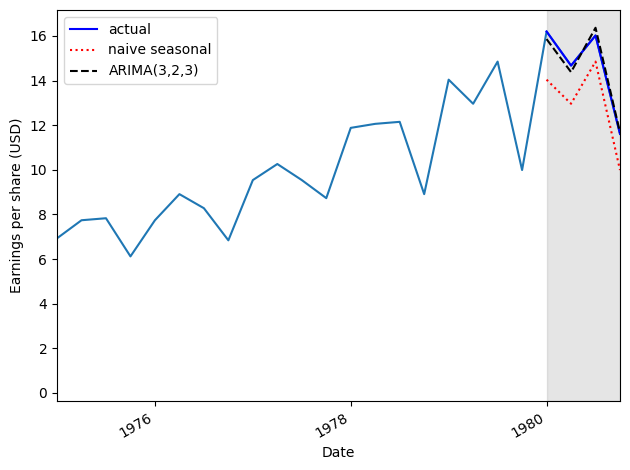

In [40]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In figure 7.8 we can see the naive seasonal forecast as a dotted line and the ARIMA(3,2,3) forecasts as a dashed line. The ARIMA(3,2,3) model predicted the quarterly EPS with a very small error.

We can quantify that error by measuring the mean absolute percentage error (MAPE) and display the metric for each forecasting method in a bar plot.

In [41]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7115897767456292


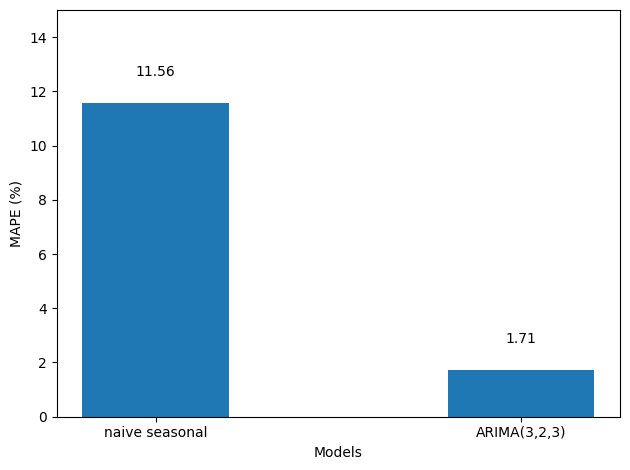

In [42]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

You can see that the MAPE for the naive seasonal forecast is 11.56%, while the MAPE for the ARIMA(3,2,3) model is 2.19%, which roughly one fifth of the benchmark value. This means that our predictions are on average 2.19% off from the actual values. The ARIMA(3,2,3) model is clearly a better model than the naive seasonal method.